In [1]:
import numpy as np

from detectors.ghostbuster.ngrams import UnigramModel, TrigramModel
from datasets import load_dataset

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
xlsum = load_dataset('anakib1/mango-truth', 'xlsum')

In [3]:
length_match = xlsum['train'].filter(lambda x: len(x['output']) < 1750)
reference = length_match.filter(lambda x: x['label'] == 0).take(1000)
generated = length_match.filter(lambda x: x['label'] == 3)

X = reference['output'] + generated['output']
y = [0] * len(reference) + [1] * len(generated)

In [6]:
unigram = UnigramModel(tokenizer_handle='gugarosa/cl100k_base')
unigram.train(X)

trigram = TrigramModel(tokenizer_handle='gugarosa/cl100k_base')
trigram.train(X)

In [7]:
from detectors.ghostbuster.openai import OpenaiProbabilityEstimator
from dotenv import load_dotenv

load_dotenv()

estimator = OpenaiProbabilityEstimator(model_name='babbage-002')

In [12]:
import random

for _ in range(10):
    i = random.randint(0, len(X) - 1)
    assert estimator.get_text_log_proba(X[i])[1].shape == unigram.get_text_log_proba(X[i])[1].shape

In [13]:
from detectors.ghostbuster.features import extract_features
from tqdm.auto import tqdm
import pickle, os

models = [unigram, trigram, estimator]

feats = []

if os.path.exists('./feats.pkl'):
    with open('./feats.pkl', 'rb') as f:
        feats = pickle.load(f)

In [14]:
for i in tqdm(range(len(feats), len(X))):
    x = X[i]
    feats.append(extract_features([model.get_text_log_proba(x)[1] for model in models]))

  0%|          | 0/4304 [00:00<?, ?it/s]

In [20]:
import pickle

with open('feats.pkl', 'wb') as f:
    pickle.dump(feats, f)

In [10]:
feats = np.stack(feats)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feats, y, shuffle=True, test_size=0.3, stratify=y)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

model = make_pipeline(StandardScaler(), CalibratedClassifierCV(LogisticRegression(C=1, max_iter=1000)))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(estimator=LogisticRegression(C=1,
                                                                     max_iter=1000)))])

In [31]:
y_test_hat = model.predict_proba(X_test)
y_train_hat = model.predict_proba(X_train)

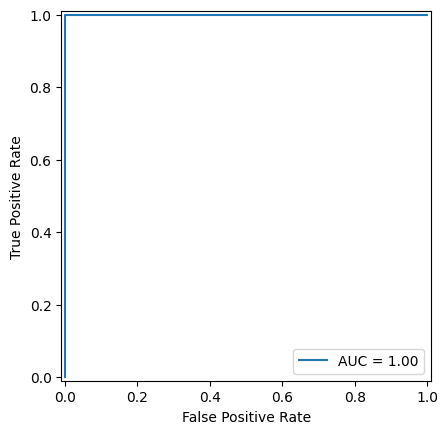

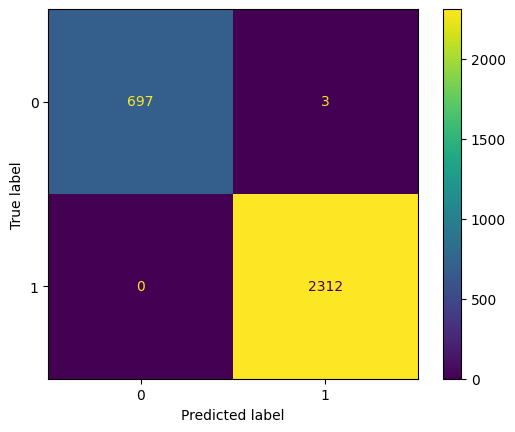

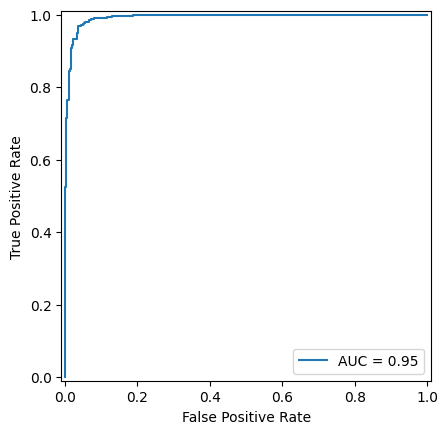

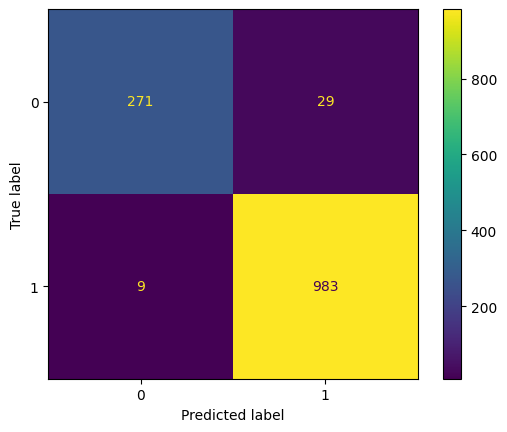

In [33]:
from detectors.neptune.nexus import NeptuneNexus
from detectors.utils.training import calculate_classification
from uuid import uuid4

train = calculate_classification(y_train, y_train_hat[:, 1])
valid = calculate_classification(y_test, y_test_hat[:, 1])

In [34]:
from detectors.ghostbuster.model import GhostbusterDetector

estimator = GhostbusterDetector(model, models)

In [35]:
from detectors.metrics import Conclusion

conclusion = Conclusion(
    weights=estimator.store_weights(),
    detector_handle='ghostbuster',
    datasets=['xlsum'],
    train_conclusion=train,
    validation_conclusion=valid
)

The OrderedVocab you are attempting to save contains holes for indices [100256, 100261, 100262, 100263, 100264, 100265, 100266, 100267, 100268, 100269, 100270, 100271, 100272, 100273, 100274, 100275], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [100256, 100261, 100262, 100263, 100264, 100265, 100266, 100267, 100268, 100269, 100270, 100271, 100272, 100273, 100274, 100275], your vocabulary could be corrupted !


In [36]:
run = uuid4()
training_nexus = NeptuneNexus()

training_nexus.conclude_run(run, conclusion=conclusion, extra_data={"info": 'CORRECT'})

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tok

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-23
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-23


In [37]:
obj = GhostbusterDetector()

obj.load_weights(training_nexus.load_run_weights(run))

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-23


Fetching file...: 0 [00:00, ?/s]